In [ ]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Input and concatenate the data

In [ ]:
all_df = []
for path in glob.glob('/content/drive/MyDrive/Data testing with IDXExchange/CRMLSSold202406-202501/*.csv'):
    df = pd.read_csv(path)
    all_df.append(df)

data = pd.concat(all_df, axis = 0, ignore_index=True)

pd.set_option('display.max_columns', None)

#### Filtering data for Residential and Single Family Residence

In [ ]:
# filter for property type and subtype
mask = (data['PropertyType'] == 'Residential') & (data['PropertySubType'] == 'SingleFamilyResidence')
data = data[mask].drop(['PropertyType','PropertySubType','OriginalListPrice', 'ListPrice'], axis = 1)
data.reset_index(drop = True, inplace = True)

#### Feature Engineering to extract month from Contract Date

In [ ]:
data['ListingContractDate_month'] = pd.to_datetime(data['ListingContractDate']).dt.month

In [ ]:
columns_to_keep = [
    "AttachedGarageYN", "BathroomsTotalInteger", "BedroomsTotal", "City",
    "ClosePrice", "CountyOrParish", "DaysOnMarket", "FireplaceYN",
    "GarageSpaces", "Latitude", "Levels", "ListingContractDate",
    "LivingArea", "Longitude", "LotSizeSquareFeet", "NewConstructionYN",
    "ParkingTotal", "PoolPrivateYN", "PostalCode", "PurchaseContractDate",
    "StateOrProvince", "Stories", "ViewYN", "YearBuilt", 'ListingContractDate_month'
]

In [ ]:
data_filtered = data[columns_to_keep]

### Data Cleaning Steps

**Boolean Columns:**  
Set NA values to `False` for Y/N features (garage, pool, fireplace, etc.).

**Location Filtering:**  
Kept only California properties (`StateOrProvince == 'CA'`).

**Smart Imputation:**  
Filled missing values by city groups:
- `Stories` & `GarageSpaces`: Mode (most common value)
- `LotSizeSquareFeet`: Median

**Column Removal:**  
Dropped:
- `Levels`: Too many nulls, low variance
- Date columns: Extracted features already captured key info

In [ ]:
# Set NA values to False for boolean columns
data_filtered["AttachedGarageYN"].fillna(False, inplace=True)
data_filtered["PoolPrivateYN"].fillna(False, inplace=True)
data_filtered["FireplaceYN"].fillna(False, inplace=True)
data_filtered["NewConstructionYN"].fillna(False, inplace=True)
data_filtered["ViewYN"].fillna(False, inplace=True)

# Data only from California
data_filtered = data_filtered[data_filtered['StateOrProvince'] == 'CA']

# Fill NA based on grouping City
data_filtered['Stories'] = data_filtered.groupby('City')['Stories'].transform(lambda x: x.fillna(x.mode()) if x.notna().any() else x)
data_filtered['LotSizeSquareFeet'] = data_filtered.groupby('City')['LotSizeSquareFeet'].transform(lambda x: x.fillna(x.median()) if x.notna().any() else x)
data_filtered['GarageSpaces'] = data_filtered.groupby('City')['GarageSpaces'].transform(lambda x: x.fillna(x.mode()) if x.notna().any() else x)

# Most levels are either "one" or "two" and it has too many null values so I decide to drop this column
data_filtered.drop(columns=['Levels'], inplace=True)

# Drop the original date columns since we've extracted the required information
data_filtered.drop(columns=["ListingContractDate", "PurchaseContractDate", "DaysOnMarket"], inplace=True)

<ipython-input-8-db6494c5642e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_filtered["AttachedGarageYN"].fillna(False, inplace=True)
<ipython-input-8-db6494c5642e>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_filtered["AttachedGarageYN"].fillna(False, inplace=True)
<ipython-input-8-db6494c5642

### Missing Stories Analysis

**Process:**
1. Grouped by `City` and checked if all `Stories` values were NaN
2. Identified cities with completely missing `Stories` data
3. Sorted and displayed affected cities

**Purpose:**  
Identify locations needing alternative imputation methods since mode-based filling won't work when all values are missing in a city group.

In [ ]:
# Group by 'PostalCode' and check if all 'Stories' are NaN within each group
missing_stories_by_postalcode = data_filtered.groupby('City')['Stories'].apply(lambda x: x.isna().all())

# Filter out the PostalCode groups where all Stories are NaN
postalcodes_with_missing_stories = missing_stories_by_postalcode[missing_stories_by_postalcode].index

# Display the PostalCodes where all 'Stories' are NaN
postalcodes_with_missing_stories.sort_values()

Index(['Aromas', 'Atherton', 'Avery', 'Ben Lomond', 'Benton', 'Berry Creek',
       'Big Sur', 'Boulder Creek', 'Brisbane', 'Brookdale', 'Burlingame',
       'Calistoga', 'Capitola', 'Carmel', 'Carmel Highlands', 'Castroville',
       'Chualar', 'Cloverdale', 'Colma', 'Columbia', 'Corralitos', 'Davenport',
       'Del Rey Oaks', 'El Granada', 'Elverta', 'Farmington', 'Foresthill',
       'Freedom', 'Gonzales', 'La Honda', 'La Selva Beach',
       'Lake Almanor Peninsula', 'Larkspur', 'Loma Mar', 'Long Barn', 'Loomis',
       'Los Altos Hills', 'Montara', 'Monte Sereno', 'Moss Beach',
       'Moss Landing', 'Mount Hermon', 'North Park (San Diego)', 'Novato',
       'O'Neals', 'Paicines', 'Pescadero', 'Pine Grove', 'Playa Vista',
       'Portola Valley', 'Prunedale', 'Royal Oaks', 'San Juan Bautista',
       'Sand City', 'Scotts Valley', 'Shingle Springs', 'Soquel', 'Spreckels',
       'Stanford', 'Surfside', 'Tahoe City', 'Tres Pinos', 'Whitmore'],
      dtype='object', name='City')

### Group-based Imputation

**Strategy:**  
Filled missing values using county-level patterns:
- `Stories` & `GarageSpaces`: Mode (most common value)
- `LotSizeSquareFeet`: Median value

**Fallback:**  
Used median when mode unavailable (empty group cases)

**Rationale:**  
County-level grouping provides better geographical relevance than city-level for these housing features.

In [ ]:
# Fill missing values in 'Stories' with the mode grouped by 'CountyOrParish'
data_filtered["Stories"] = data_filtered.groupby("CountyOrParish")["Stories"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.median()))

# Fill missing values in 'LotSizeSquareFeet' with the median grouped by 'CountyOrParish'
data_filtered["LotSizeSquareFeet"] = data_filtered.groupby("CountyOrParish")["LotSizeSquareFeet"].transform(lambda x: x.fillna(x.median()))

# Fill missing values in 'GarageSpaces' with the mode grouped by 'CountyOrParish'
data_filtered["GarageSpaces"] = data_filtered.groupby("CountyOrParish")["GarageSpaces"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.median()))

Showing how many percentage loss so far compared to the original dataset.

In [ ]:
print('Percentage loss: ', (1 - (data_filtered.shape[0]) / 91072) * 100)

Percentage loss:  0.0076862262824994865


### Outlier Detection & Removal

**Method:**  
IQR technique (**Q1 - 1.5 IQR** to **Q3 + 1.5 IQR** range) applied to:
- `ClosePrice`
- `BedroomsTotal`
- `LivingArea`
- `BathroomsTotalInteger`

**Output:**  
Prints percentage of data lost per feature

**Additional Filter:**  
Kept only properties with non-negative `ParkingTotal`

**Commented Options:**  
Shows other potential features considered for outlier removal

In [ ]:
def quantile(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    outliers = df[(df[column_name] < Q1 - 1.5 * IQR) | (df[column_name] > Q3 + 1.5 * IQR)]
    print("Percentage loss from outliers: ", (len(outliers) / len(df)) * 100, "%")

    df_filtered = df[(df[column_name] >= Q1 - 1.5 * IQR) & (df[column_name] <= Q3 + 1.5 * IQR)]

    return df_filtered

In [ ]:
data_filtered = quantile(data_filtered, 'ClosePrice')
# data_filtered = quantile(data_filtered, 'ClosePrice')
data_filtered = quantile(data_filtered, 'BedroomsTotal')
data_filtered = quantile(data_filtered, 'LivingArea')
data_filtered = quantile(data_filtered, 'BathroomsTotalInteger')
# data_filtered = quantile(data_filtered, 'LotSizeSquareFeet')
# data_filtered = quantile(data_filtered, 'GarageSpaces')
# data_filtered = quantile(data_filtered, 'ParkingTotal')

data_filtered = data_filtered[data_filtered['ParkingTotal'] >= 0]

Percentage loss from outliers:  7.313457420523801 %
Percentage loss from outliers:  2.1823868819828682 %
Percentage loss from outliers:  2.5774881602693767 %
Percentage loss from outliers:  0.8866835795652389 %


### Feature Engineering: Building Age

**Calculation:**  
`Age = 2025 - YearBuilt`  
(Current year minus construction year)

**Cleanup:**  
Dropped original `YearBuilt` column after age calculation

In [ ]:
# Calculating the 'Age' of the building
data_filtered['Age'] = 2025 - data_filtered['YearBuilt']
data_filtered.drop(columns=['YearBuilt'], inplace=True)

In [ ]:
print('Percentage loss: ', (1 - (data_filtered.shape[0]) / 91072) * 100)

Percentage loss:  12.527450808151796


We lost 12.52745 % after filtering data

In [ ]:
data_filtered.isnull().sum()

,0
AttachedGarageYN,0
BathroomsTotalInteger,0
BedroomsTotal,0
City,80
ClosePrice,0
CountyOrParish,0
FireplaceYN,0
GarageSpaces,0
Latitude,25
LivingArea,0


In [ ]:
data_filtered.shape

(79663, 21)

In [ ]:
data_filtered.dropna(inplace=True)
data_filtered.reset_index(drop=True, inplace=True)

print('Percentage loss: ', (1 - (data_filtered.shape[0]) / 91072) * 100)

Percentage loss:  12.659214687280397


### Boolean Conversion

**Action:**  
Converted Y/N columns to binary (1/0):  
`AttachedGarageYN`, `FireplaceYN`, `NewConstructionYN`, `PoolPrivateYN`, `ViewYN`

**Purpose:**  
Prepares categorical features for machine learning algorithms

In [ ]:
# List of boolean columns
boolean_columns = ['AttachedGarageYN', 'FireplaceYN', 'NewConstructionYN', 'PoolPrivateYN', 'ViewYN']

# Convert the boolean columns to 1 and 0
data_filtered[boolean_columns] = data_filtered[boolean_columns].astype(int)

In [ ]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79543 entries, 0 to 79542
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AttachedGarageYN           79543 non-null  int64  
 1   BathroomsTotalInteger      79543 non-null  float64
 2   BedroomsTotal              79543 non-null  float64
 3   City                       79543 non-null  object 
 4   ClosePrice                 79543 non-null  float64
 5   CountyOrParish             79543 non-null  object 
 6   FireplaceYN                79543 non-null  int64  
 7   GarageSpaces               79543 non-null  float64
 8   Latitude                   79543 non-null  float64
 9   LivingArea                 79543 non-null  float64
 10  Longitude                  79543 non-null  float64
 11  LotSizeSquareFeet          79543 non-null  float64
 12  NewConstructionYN          79543 non-null  int64  
 13  ParkingTotal               79543 non-null  flo

### Data Type Conversion

**Action:**  
Converted columns to float64:  
- Boolean flags (`YN` columns)  
- Month from contract date  

**Verification:**  
Checked dtype conversion for all specified columns  

**Purpose:**  
Ensures numerical consistency for modeling

In [ ]:
columns_to_convert = [
    "AttachedGarageYN", "FireplaceYN", "NewConstructionYN",
    "PoolPrivateYN", "ViewYN", "ListingContractDate_month"
]

data_filtered[columns_to_convert] = data_filtered[columns_to_convert].astype('float64')

# Verify conversion
data_filtered.dtypes.loc[columns_to_convert]

,0
AttachedGarageYN,float64
FireplaceYN,float64
NewConstructionYN,float64
PoolPrivateYN,float64
ViewYN,float64
ListingContractDate_month,float64


### Log Transformation

**Action:**  
Applied log transform to `ClosePrice` to handle skewness  

**Visualization:**  
Generated histogram to verify normalized distribution  

**Purpose:**  
Improves model performance by:  
- Reducing right-skew  
- Normalizing price distribution  
- Minimizing outlier impact

In [ ]:
# Log Transformation method
data_filtered["log_ClosePrice"] = np.log(data_filtered["ClosePrice"])

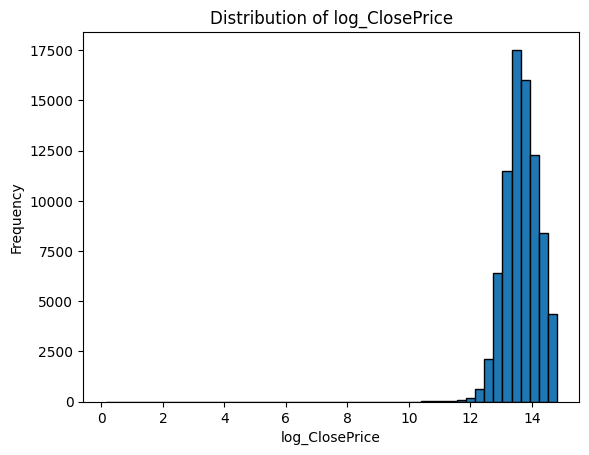

In [ ]:
plt.hist(data_filtered['log_ClosePrice'], bins=50, edgecolor='black')
plt.xlabel('log_ClosePrice')
plt.ylabel('Frequency')
plt.title('Distribution of log_ClosePrice')
plt.show()

### Square Root Transformation

**Action:**  
Applied √ transform to `ClosePrice` as alternative normalization  

**Output:**  
Histogram shows transformed distribution  

**Purpose:**  
- Reduces right-skew (less aggressive than log)  
- Preserves original units better than log  
- Maintains interpretability  

In [ ]:
# Square Root Transformation method
data_filtered['ClosePrice_sqrt'] = np.sqrt(data_filtered['ClosePrice'])

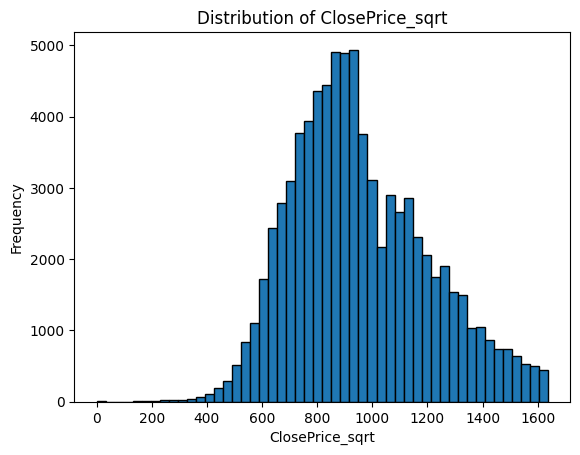

In [ ]:
plt.hist(data_filtered['ClosePrice_sqrt'], bins=50, edgecolor='black')
plt.xlabel('ClosePrice_sqrt')
plt.ylabel('Frequency')
plt.title('Distribution of ClosePrice_sqrt')
plt.show()

### Final Processing

**Columns Removed:**
- Geographic identifiers (`City`, `CountyOrParish`, `PostalCode`, `StateOrProvince`)  
- Raw & transformed prices (`ClosePrice`, `ClosePrice_sqrt`)  

**Output:**  
Saved cleaned dataset as CSV with:  
- Only modeling-ready features  
- Log-transformed target (`log_ClosePrice`)  
- No index column

In [ ]:
data_filtered.drop(columns=["City", "CountyOrParish", "PostalCode", "StateOrProvince", "ClosePrice", "ClosePrice_sqrt"], inplace=True)

In [ ]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79543 entries, 0 to 79542
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AttachedGarageYN           79543 non-null  float64
 1   BathroomsTotalInteger      79543 non-null  float64
 2   BedroomsTotal              79543 non-null  float64
 3   FireplaceYN                79543 non-null  float64
 4   GarageSpaces               79543 non-null  float64
 5   Latitude                   79543 non-null  float64
 6   LivingArea                 79543 non-null  float64
 7   Longitude                  79543 non-null  float64
 8   LotSizeSquareFeet          79543 non-null  float64
 9   NewConstructionYN          79543 non-null  float64
 10  ParkingTotal               79543 non-null  float64
 11  PoolPrivateYN              79543 non-null  float64
 12  Stories                    79543 non-null  float64
 13  ViewYN                     79543 non-null  flo

In [ ]:
save_path = '/content/drive/MyDrive/Data testing with IDXExchange/data_filtered-6nd-log_ClosePrice.csv'
data_filtered.to_csv(save_path, index=False)